# Lab 8 - Feature Selection and Principal Component Analysis (PCA)

Here, we will analyze the impact of dimensionality by running one model with some selected features and then with some extracted features. The model selected is Random Forest with the estimators considered the "best" on the lab_05 tests, because it gave us the best results so far.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from utils import modelAnalyzesFunctions as analyzes, graphFunctions as graph
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

In [3]:
data: pd.DataFrame = pd.read_csv('../datasets/covtype_data_preparation.csv', sep=',', decimal='.')
copy_data = data.copy()
y: np.ndarray = copy_data.pop('Cover_Type').values
X: np.ndarray = copy_data.values
labels = pd.unique(y)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type-32,Soil_Type-33,Soil_Type-34,Soil_Type-35,Soil_Type-36,Soil_Type-37,Soil_Type-38,Soil_Type-39,Soil_Type-40,Cover_Type
0,0.546773,0.200000,0.454545,0.047960,0.272610,0.367290,0.937008,0.665354,0.161417,0.308518,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.637819,0.891667,0.090909,0.064424,0.223514,0.105381,0.803150,0.921260,0.665354,0.158929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.716858,0.163889,0.287879,0.125268,0.232558,0.593790,0.905512,0.771654,0.354331,0.500209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.549775,0.133333,0.106061,0.021475,0.228682,0.437544,0.877953,0.885827,0.543307,0.157814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.699850,0.519444,0.121212,0.336435,0.295866,0.360264,0.870079,0.968504,0.625984,0.191552,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Feature Selection

In [4]:
selector_chi = SelectKBest(chi2, k=2)
X_new = selector_chi.fit_transform(X, y)
copy_data.columns[selector_chi.get_support()]

Index(['Wilderness_Area-4', 'Soil_Type-3'], dtype='object')

In [5]:
selector_f = SelectKBest(mutual_info_classif, k=2)
X_new = selector_f.fit_transform(X, y)
copy_data.columns[selector_f.get_support()]

Index(['Elevation', 'Wilderness_Area-4'], dtype='object')

In [6]:
n_estimators = 250
max_depth = 50
max_features = 'sqrt'

n_splits = 4
n_repeats = 3

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_rf, sensitivity_rf = analyzes.random_forest(X, y, rskf, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, average='micro')

print("Baseline accuracy: ", accuracy_rf)
print("Baseline sensitivity: ", sensitivity_rf)

Baseline accuracy:  0.8683584653895423
Baseline sensitivity:  0.8683584653895423


In [7]:
def random_forest_with_n_features(X, y, rskf, n_estimators, max_depth, max_features, n_features, estimator):
    accuracies = np.zeros(len(n_features))
    sensitivities = np.zeros(len(n_features))
    for n in range(len(n_features)):
        selector = SelectKBest(estimator, k=n_features[n])
        X_new = selector.fit_transform(X, y)
        acc, sens = analyzes.random_forest(X_new, y, rskf, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, average='micro')
        accuracies[n] = acc
        sensitivities[n] = sens
    return accuracies, sensitivities

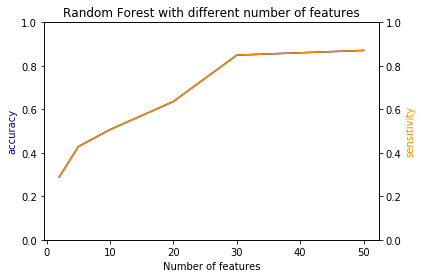

Best accuracy: 0.8708722519991569
Sensitivity associated: 0.8708722519991569
Number of features 50 

Best sensitivity: 0.8708722519991569
Accuracy associated: 0.8708722519991569
Number of features 50 



In [8]:
n_features = [2, 5, 10, 20, 30, 50]

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_rf_chi, sensitivities_rf_chi = random_forest_with_n_features(X, y, rskf, n_estimators, max_depth, max_features, n_features, chi2)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_rf_chi, sensitivities_rf_chi, 'Random Forest with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0, 1), y_interval2=(0, 1))
plt.show()
print("Best accuracy:", np.max(accuracies_rf_chi))
print("Sensitivity associated:", sensitivities_rf_chi[np.argmax(accuracies_rf_chi)])
print("Number of features", n_features[np.argmax(accuracies_rf_chi)], '\n')
print("Best sensitivity:", np.max(sensitivities_rf_chi))
print("Accuracy associated:", accuracies_rf_chi[np.argmax(sensitivities_rf_chi)])
print("Number of features", n_features[np.argmax(sensitivities_rf_chi)], '\n')

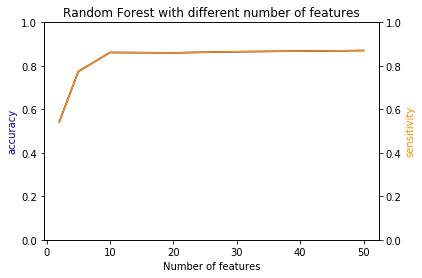

Best accuracy: 0.8704560619958408
Sensitivity associated: 0.8704560619958408
Number of features 50 

Best sensitivity: 0.8704560619958408
Accuracy associated: 0.8704560619958408
Number of features 50 



In [9]:
n_features = [2, 5, 10, 20, 30, 50]

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_rf_mut, sensitivities_rf_mut = random_forest_with_n_features(X, y, rskf, n_estimators, max_depth, max_features, n_features, mutual_info_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_rf_mut, sensitivities_rf_mut, 'Random Forest with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0, 1), y_interval2=(0, 1))
plt.show()
print("Best accuracy:", np.max(accuracies_rf_mut))
print("Sensitivity associated:", sensitivities_rf_mut[np.argmax(accuracies_rf_mut)])
print("Number of features", n_features[np.argmax(accuracies_rf_mut)], '\n')
print("Best sensitivity:", np.max(sensitivities_rf_mut))
print("Accuracy associated:", accuracies_rf_mut[np.argmax(sensitivities_rf_mut)])
print("Number of features", n_features[np.argmax(sensitivities_rf_mut)], '\n')

In both cases, the accuracy stabilizes after certain number of features.

To compare the effect of the number of features between one ensemble method (random forest) and a single model, we will try the same approach with KNN.

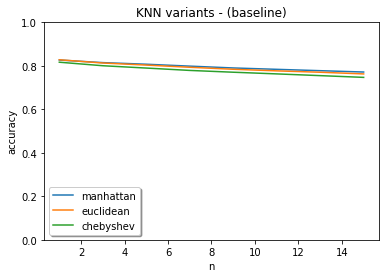

Accuracy for n equal to 1 : 0.8267
Sensitivity for n equal to 1 : 0.8267 

Accuracy for n equal to 3 : 0.8149
Sensitivity for n equal to 3 : 0.8149 

Accuracy for n equal to 5 : 0.8074
Sensitivity for n equal to 5 : 0.8074 

Accuracy for n equal to 7 : 0.7987
Sensitivity for n equal to 7 : 0.7987 

Accuracy for n equal to 9 : 0.7903
Sensitivity for n equal to 9 : 0.7903 

Accuracy for n equal to 11 : 0.7840
Sensitivity for n equal to 11 : 0.7840 

Accuracy for n equal to 13 : 0.7778
Sensitivity for n equal to 13 : 0.7778 

Accuracy for n equal to 15 : 0.7716
Sensitivity for n equal to 15 : 0.7716 



In [10]:
nvalues = [1, 3, 5, 7, 9, 11, 13, 15]
dist = ['manhattan', 'euclidean', 'chebyshev']

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_knn, sensitivity_knn = analyzes.knn_analyzes(X, y, nvalues, dist, rskf, title_complement = '- (baseline)', average='micro')

In [11]:
def knn_with_n_features(X, y, nvalue, dist, rskf, n_features, estimator):
    accuracies = np.zeros(len(n_features))
    sensitivities = np.zeros(len(n_features))
    for n in range(len(n_features)):
        selector = SelectKBest(estimator, k=n_features[n])
        X_new = selector.fit_transform(X, y)
        acc, sens = analyzes.knn(X_new, y, nvalue, dist, rskf, average='micro')
        accuracies[n] = acc
        sensitivities[n] = sens
    return accuracies, sensitivities

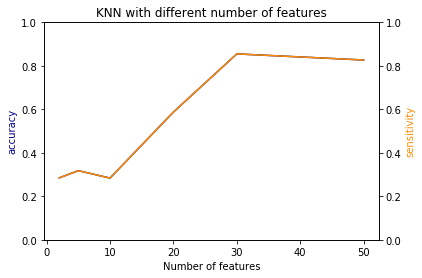

Best accuracy: 0.854941010952698
Sensitivity associated: 0.854941010952698
Number of features 30 

Best sensitivity: 0.854941010952698
Accuracy associated: 0.854941010952698
Number of features 30 



In [12]:
n_features = [2, 5, 10, 20, 30, 50]

nvalue = 1
dist = 'manhattan'

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_knn_chi, sensitivities_knn_chi = knn_with_n_features(X, y, nvalue, dist, rskf, n_features, chi2)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_knn_chi, sensitivities_knn_chi, 'KNN with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0, 1), y_interval2=(0, 1))
plt.show()
print("Best accuracy:", np.max(accuracies_knn_chi))
print("Sensitivity associated:", sensitivities_knn_chi[np.argmax(accuracies_knn_chi)])
print("Number of features", n_features[np.argmax(accuracies_knn_chi)], '\n')
print("Best sensitivity:", np.max(sensitivities_knn_chi))
print("Accuracy associated:", accuracies_knn_chi[np.argmax(sensitivities_knn_chi)])
print("Number of features", n_features[np.argmax(sensitivities_knn_chi)], '\n')

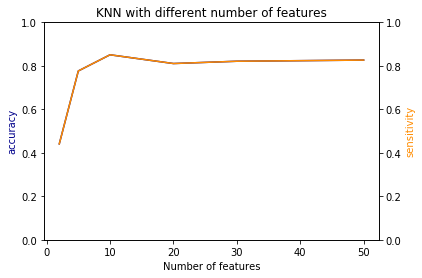

Best accuracy: 0.8508494358144887
Sensitivity associated: 0.8508494358144887
Number of features 10 

Best sensitivity: 0.8508494358144887
Accuracy associated: 0.8508494358144887
Number of features 10 



In [13]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_knn_mut, sensitivities_knn_mut = knn_with_n_features(X, y, nvalue, dist, rskf, n_features, mutual_info_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_knn_mut, sensitivities_knn_mut, 'KNN with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0, 1), y_interval2=(0, 1))
plt.show()
print("Best accuracy:", np.max(accuracies_knn_mut))
print("Sensitivity associated:", sensitivities_knn_mut[np.argmax(accuracies_knn_mut)])
print("Number of features", n_features[np.argmax(accuracies_knn_mut)], '\n')
print("Best sensitivity:", np.max(sensitivities_knn_mut))
print("Accuracy associated:", accuracies_knn_mut[np.argmax(sensitivities_knn_mut)])
print("Number of features", n_features[np.argmax(sensitivities_knn_mut)], '\n')

Even though we have 55 columns on the dataset, most of them (44 to be exactly) are dummified, therefore the effect of adding/removing is explained by only its relevance to predict the target class (different than the parkinson dataset that had more than 300 features for less than 1000 records ==> "the curse of dimensionality" was applied).

## PCA

There will be created enough components to explain around 85% of the dataset variation (commonly used number of cumulative percentage explained for PCA).

In [14]:
pca = PCA(n_components=0.85, svd_solver="full")
pca.fit(X)

X_pca = pca.transform(X)

print("Explained variance (ratio) =",pca.explained_variance_ratio_)
print("Number of features extracted =", len(pca.explained_variance_ratio_))
print("Total explained variance =", np.sum(pca.explained_variance_ratio_))

Explained variance (ratio) = [0.22015994 0.18202446 0.06862315 0.05448283 0.03677052 0.03384975
 0.03066136 0.02817159 0.02686661 0.02456993 0.02347218 0.0223183
 0.02213372 0.02151387 0.01898084 0.01679982 0.01593079 0.01487761]
Number of features extracted = 18
Total explained variance = 0.8622072597128196


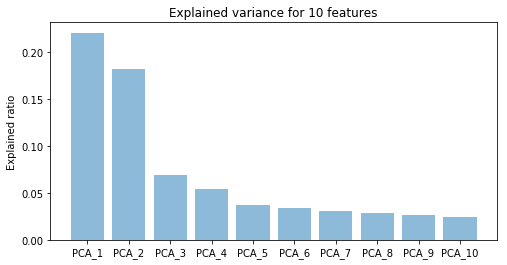

In [15]:
fig = plt.figure(figsize=(8,4))

plotted_features = 10 if len(pca.explained_variance_ratio_) > 10 else len(pca.explained_variance_ratio_)
variables = []
for i in range(plotted_features):
    variables.append('PCA_'+str((i+1)))
y_pos = np.arange(len(variables))
ratio = pca.explained_variance_ratio_[0:plotted_features]

plt.bar(y_pos, ratio, align='center', alpha=0.5)
plt.xticks(y_pos, variables)
plt.ylabel('Explained ratio')
plt.title('Explained variance for ' +str(plotted_features)+ ' features')

plt.show()

In [16]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_pca_rf, sensitivity_pca_rf = analyzes.random_forest(X_pca, y, rskf, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, average='micro')

print("Accuracy:", accuracy_pca_rf)
print("Sensitivity:", sensitivity_pca_rf)

Accuracy: 0.8294238855272376
Sensitivity: 0.8294238855272376


In [17]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_pca_knn, sensitivity_pca_knn = analyzes.knn(X_pca, y, nvalue, dist, rskf, average='micro')

print("Accuracy:", accuracy_pca_knn)
print("Sensitivity:", sensitivity_pca_knn)

Accuracy: 0.8006477670532313
Sensitivity: 0.8006477670532313


In both cases, the results on feature selection was a little better than the ones obtained by feature extraction.